In [2]:
import sys
# !{sys.executable} -m pip  install optuna
# !{sys.executable} -m pip  install mlxtend

In [2]:
import os

import psycopg
import pandas as pd
import mlflow
from catboost import CatBoostClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

TABLE_NAME = 'users_churn'
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

EXPERIMENT_NAME = 'churn_task_alexdem'
RUN_NAME = "feature_selection"
REGISTRY_MODEL_NAME = 'churn_model_alexdem_b2c'
FS_ASSETS = "fs_assets" 


/home/mle-user/.local/lib/python3.10/site-packages/pydantic/_internal/_fields.py:149: UserWarning: Field "model_server_url" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/home/mle-user/.local/lib/python3.10/site-packages/pydantic/_internal/_config.py:321: UserWarning: Valid config keys have changed in V2:
* 'schema_extra' has been renamed to 'json_schema_extra'
  warnings.warn(message, UserWarning)


### Загрузка данных

In [3]:
# credentials

connection = {"sslmode": "require", "target_session_attrs": "read-write"}
postgres_credentials = {
    "host": os.getenv("DB_DESTINATION_HOST"),
    "port": os.getenv("DB_DESTINATION_PORT"),
    "dbname": os.getenv("DB_DESTINATION_NAME"),
    "user": os.getenv("DB_DESTINATION_USER"),
    "password": os.getenv("DB_DESTINATION_PASSWORD"),
}

connection.update(postgres_credentials)

TABLE_NAME = 'users_churn'


In [4]:
with psycopg.connect(**connection) as conn:

    with conn.cursor() as cur:
        cur.execute(f"SELECT * FROM {TABLE_NAME}")
        data = cur.fetchall()
        columns = [col[0] for col in cur.description]

df = pd.DataFrame(data, columns=columns)

df.head(2) 

,id,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,...,device_protection,tech_support,streaming_tv,gender,streaming_movies,senior_citizen,partner,dependents,multiple_lines,target
0,1,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,...,No,No,No,Female,No,0,Yes,No,None,0
1,2,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,DSL,...,Yes,No,No,Male,No,0,No,No,No,0


In [5]:
cat_features = [
    'paperless_billing',
    'payment_method',
    'internet_service',
    'online_security',
    'online_backup',
    'device_protection',
    'tech_support',
    'streaming_tv',
    'streaming_movies',
    'gender',
    'senior_citizen',
    'partner',
    'dependents',
    'multiple_lines',
    'type'
]
num_features = ["monthly_charges", "total_charges"]
target = ['target'] # колонка с таргетом вашей модели
df[num_features] = df[num_features].fillna(0)

df['senior_citizen'] = df['senior_citizen'].map({1:'Yes', 0:'No'})

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df[cat_features + num_features], df['target'], test_size=0.4)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

### Отбор признаков

In [7]:
import numpy as np

In [27]:
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net"
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID")
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY")

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

EXPERIMENT_NAME = 'churn_preprocessing_alexndem'
RUN_NAME = "feature_selection" 
REGISTRY_MODEL_NAME = 'churn_model_alexndem'

FS_ASSETS = "fs_assets" 

In [9]:
logged_transformer = 'runs:/01e47211b28c4a6cbc96fc7f9302b453/column_transformer'

# Load model
logged_transformer = mlflow.sklearn.load_model(logged_transformer)

/home/mle-user/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
X_train_features = logged_transformer.transform(X_train)
X_train_features = pd.DataFrame(X_train_features, columns=logged_transformer.get_feature_names_out())

X_test_features = logged_transformer.transform(X_test)
X_test_features = pd.DataFrame(X_test_features, columns=logged_transformer.get_feature_names_out())

X_val_features = logged_transformer.transform(X_val)
X_val_features = pd.DataFrame(X_val_features, columns=logged_transformer.get_feature_names_out())


In [21]:
feature_names = [feature for feature in logged_transformer.get_feature_names_out() if not ('num__spl' in feature or 'num__pol' in feature)]

X_train_features = X_train_features[feature_names]
X_test_features = X_test_features[feature_names]
X_val_features = X_val_features[feature_names]



In [22]:
estimator = RandomForestClassifier(n_estimators=300)

sfs = SFS(estimator, k_features=10, forward=True, floating=False, scoring='roc_auc', verbose=2, cv=4, n_jobs=-1)
sbs = SFS(estimator=estimator, k_features=10, forward=False, cv=4, scoring='roc_auc', floating=False, verbose=2, n_jobs=-1)

sfs = sfs.fit(X_train_features, y_train)
sbs = sbs.fit(X_train_features, y_train)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



[2025-06-04 19:54:53] Features: 1/10 -- score: 0.6766239240734837[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.

[2025-06-04 19:55:21] Features: 2/10 -- score: 0.763664832886511[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.

[2025-06-04 19:55:46] Features: 3/10 -- score: 0.7953317104014873[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.

[2025-06-04 19:56:11] Features: 4/10 -- score: 0.8134389171246915[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.

[2025-06-04 19:56:33] Features: 5/10 -- score: 0.8230127946915197[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.

[2025-06-04 19:56:54] Features: 6/10 -- score: 0.8259858138696738[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.

[2025-06-04 19:57:13] Features: 7/10 -- score: 0.8273538893231216[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.

[2025-

In [23]:
top_sfs = sfs.k_feature_names_
top_sbs = sbs.k_feature_names_

print('\nSequential Forward Selection (k=10)')
print('CV Score:')
print(sfs.k_score_)

print('\nSequential Backward Selection')
print('CV Score:')
print(sbs.k_score_)


Sequential Forward Selection (k=10)
CV Score:
0.8096644343151903

Sequential Backward Selection
CV Score:
0.8089190455317122


In [24]:
sfs_df = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
sbs_df = pd.DataFrame.from_dict(sbs.get_metric_dict()).T 

In [25]:
sfs_df

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(11,)","[0.6809994545950367, 0.6653834926658396, 0.679...",0.676624,"(cat__encoder__internet_service_Fiber optic,)",0.010432,0.006508,0.003757
2,"(5, 11)","[0.7649622761567131, 0.7478563088374809, 0.760...",0.763665,"(num__kbd__total_charges, cat__encoder__intern...",0.019024,0.011868,0.006852
3,"(5, 7, 11)","[0.8056381238069267, 0.7824860432022185, 0.786...",0.795332,"(num__kbd__total_charges, cat__encoder__type_T...",0.017526,0.010934,0.006313
4,"(5, 6, 7, 11)","[0.8258771929824562, 0.8007826753265708, 0.813...",0.813439,"(num__kbd__total_charges, cat__encoder__type_O...",0.014228,0.008876,0.005125
5,"(5, 6, 7, 9, 11)","[0.8217139350968093, 0.8143768700284609, 0.826...",0.823013,"(num__kbd__total_charges, cat__encoder__type_O...",0.009067,0.005656,0.003266
6,"(5, 6, 7, 9, 11, 12)","[0.8264885010453595, 0.818912829307451, 0.8252...",0.825986,"(num__kbd__total_charges, cat__encoder__type_O...",0.008193,0.005111,0.002951
7,"(4, 5, 6, 7, 9, 11, 12)","[0.8338832833378784, 0.8089378238341969, 0.833...",0.827354,"(num__kbd__monthly_charges, num__kbd__total_ch...",0.017049,0.010636,0.006141
8,"(4, 5, 6, 7, 9, 10, 11, 12)","[0.8212776111262613, 0.8059047288914836, 0.827...",0.821489,"(num__kbd__monthly_charges, num__kbd__total_ch...",0.015514,0.009678,0.005588
9,"(4, 5, 6, 7, 8, 9, 10, 11, 12)","[0.8135578583765113, 0.8034919360723928, 0.830...",0.8186,"(num__kbd__monthly_charges, num__kbd__total_ch...",0.017265,0.01077,0.006218
10,"(4, 5, 6, 7, 8, 9, 10, 11, 12, 13)","[0.8028088355604035, 0.79586130774283, 0.82043...",0.809664,"(num__kbd__monthly_charges, num__kbd__total_ch...",0.017027,0.010622,0.006133


In [28]:
os.mkdir(FS_ASSETS)

sfs_df.to_csv(f"{FS_ASSETS}/sfs.csv")
sbs_df.to_csv(f"{FS_ASSETS}/sbs.csv") 

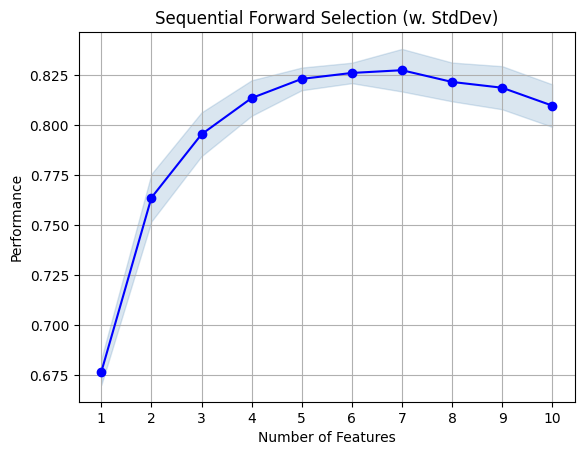

<Figure size 640x480 with 0 Axes>

In [30]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

plt.savefig(f"{FS_ASSETS}/sfs.png") 

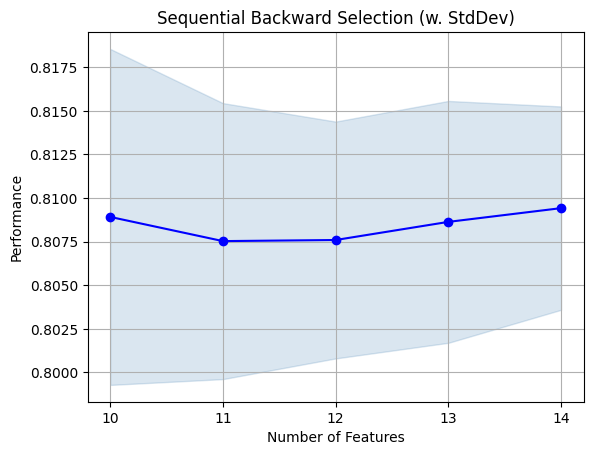

<Figure size 640x480 with 0 Axes>

In [31]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig = plot_sfs(sbs.get_metric_dict(), kind='std_dev')

plt.title('Sequential Backward Selection (w. StdDev)')
plt.grid()
plt.show()

plt.savefig(f"{FS_ASSETS}/sbs.png") 

In [32]:
interc_features = list(set(top_sbs) & set(top_sfs))
union_features = list(set(top_sbs) | set(top_sfs))

In [34]:
interc_features

['cat__encoder__payment_method_Electronic check',
 'cat__encoder__internet_service_Fiber optic',
 'cat__encoder__type_One year',
 'num__kbd__monthly_charges',
 'cat__encoder__gender_Male',
 'num__kbd__total_charges',
 'cat__encoder__type_Two year']

In [35]:
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=f"{RUN_NAME}_intersection_and_union", experiment_id=experiment_id) as run:
    run_id = run.info.run_id
   
    mlflow.log_artifacts(FS_ASSETS) 

### Логирование модели

In [37]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, confusion_matrix, precision_score, recall_score, f1_score, log_loss

from catboost import CatBoostClassifier
from sklearn.metrics import mean_absolute_error, auc

In [38]:
model_interc = CatBoostClassifier(iterations=300, verbose=False)
model_interc.fit(X_train_features[interc_features], y_train)
proba_interc = model_interc.predict_proba(X_test_features[interc_features])[:, 1]
prediction_interc = model_interc.predict(X_test_features[interc_features])

In [39]:
model_union = CatBoostClassifier(iterations=300, verbose=False)
model_union.fit(X_train_features[union_features], y_train)
proba_union = model_union.predict_proba(X_test_features[union_features])[:, 1]
prediction_union = model_union.predict(X_test_features[union_features])

'50987e412e7d4769a4805e423027d673'

In [40]:
EXPERIMENT_NAME = "churn_task_alexdem"
RUN_NAME = "model_interc"
REGISTRY_MODEL_NAME = "churn_model_alexdem_b2c"

pip_requirements= "./requirements.txt"
signature = mlflow.models.infer_signature(X_test_features[interc_features].values, prediction_interc)
input_example = X_test_features[interc_features][:10]
metadata = {'model_type': 'monthly'}


experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    
    model_info = mlflow.catboost.log_model( 
			cb_model=model_interc,
            artifact_path="models",
            registered_model_name=REGISTRY_MODEL_NAME,
            pip_requirements=pip_requirements,
            signature=signature,
            input_example=input_example,
            metadata=metadata,
            await_registration_for=60
		)
    _, err1, _, err2 = confusion_matrix(y_test, prediction_interc).ravel()
    auc = roc_auc_score(y_test, proba_interc)
    logloss = log_loss(y_test, proba_interc)
    mlflow.log_metrics({'auc': auc, 'logloss': logloss, 'err1': err1, 'err2': err2})

Registered model 'churn_model_alexdem_b2c' already exists. Creating a new version of this model...
2025/06/04 20:17:35 INFO mlflow.tracking._model_registry.client: Waiting up to 60 seconds for model version to finish creation. Model name: churn_model_alexdem_b2c, version 7
Created version '7' of model 'churn_model_alexdem_b2c'.


In [41]:
EXPERIMENT_NAME = "churn_task_alexdem"
RUN_NAME = "model_union"
REGISTRY_MODEL_NAME = "churn_model_alexdem_b2c"

pip_requirements= "./requirements.txt"
signature = mlflow.models.infer_signature(X_test_features[union_features].values, prediction_union)
input_example = X_test_features[union_features][:10]
metadata = {'model_type': 'monthly'}


experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    
    model_info = mlflow.catboost.log_model( 
			cb_model=model_union,
            artifact_path="models",
            registered_model_name=REGISTRY_MODEL_NAME,
            pip_requirements=pip_requirements,
            signature=signature,
            input_example=input_example,
            metadata=metadata,
            await_registration_for=60
		)
    _, err1, _, err2 = confusion_matrix(y_test, prediction_union).ravel()
    auc = roc_auc_score(y_test, proba_union)
    logloss = log_loss(y_test, proba_union)
    mlflow.log_metrics({'auc': auc, 'logloss': logloss, 'err1': err1, 'err2': err2})

/home/mle-user/.local/lib/python3.10/site-packages/_distutils_hack/__init__.py:15: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/mle-user/.local/lib/python3.10/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
Registered model 'churn_model_alexdem_b2c' already exists. Creating a new version of this model...
2025/06/04 20:17:37 INFO mlflow.tracking._